## Meta元学习估计ATE/ITE
这里参考官方文档：[meta_learners_with_synthetic_data.ipynb](https://cloud.tencent.com/developer/tools/blog-entry?target=https%3A%2F%2Fgithub.com%2Fuber%2Fcausalml%2Fblob%2F27a55f59ce10806ad5ae65593cedd915dce19d99%2Fexamples%2Fmeta_learners_with_synthetic_data.ipynb&source=article&objectId=1913941)

当然，这里注意到该教程中干预是0/1二分类的。

那么后面有一份类似的教程，是，干预可以是`multiple_treatment`所以可以参考[meta_learners_with_synthetic_data_multiple_treatment.ipynb](https://cloud.tencent.com/developer/tools/blog-entry?target=https%3A%2F%2Fgithub.com%2Fuber%2Fcausalml%2Fblob%2F27a55f59ce10806ad5ae65593cedd915dce19d99%2Fexamples%2Fmeta_learners_with_synthetic_data_multiple_treatment.ipynb&source=article&objectId=1913941)

CausalML 是一个 Python 包，它使用基于最新研究的机器学习算法提供了一套提升建模和因果推理方法。它提供了一个标准接口，允许用户从实验或观察数据中估计条件平均治疗效果（CATE）或个体治疗效果（ITE）。本质上，它估计干预 T 对具有观察到的特征 X 的用户的结果 Y 的因果影响，而无需对模型形式做出强有力的假设。该包目前支持以下方法：基于树的算法基于 KL 散度、欧几里得距离和卡方提升树/随机森林基于上下文治疗选择的提升树/随机森林元学习者算法 S-learner T-learner X-learner R-learner 在此笔记本中，我们将生成一些合成数据来演示如何使用各种元学习者算法来估计个体治疗效果（以及带有置信区间的平均治疗效果）

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from xgboost import XGBRegressor
import warnings

from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel
from causalml.dataset import synthetic_data
from causalml.dataset import *
from causalml.metrics import *

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

%matplotlib inline

import causalml
# print(causalml.__version__)

In [2]:
# 生成数据 Generate synthetic data using model 1
y, X, treatment, tau, b, e = synthetic_data(mode=1, n=10000, p=8, sigma=1.0)

# 这里 y - 因变量, X-协变量, treatment-干预, e - PS倾向性得分
y, X, treatment, tau, b, e

(array([0.37146652, 2.54313375, 2.23172766, ..., 1.26777357, 3.34209572,
        1.01543143]),
 array([[0.17135015, 0.28781219, 0.35134408, ..., 0.15495865, 0.65213942,
         0.01172929],
        [0.27540984, 0.599331  , 0.35899232, ..., 0.06232577, 0.68348669,
         0.1793419 ],
        [0.50110487, 0.57952853, 0.56819703, ..., 0.10020628, 0.72219283,
         0.16101668],
        ...,
        [0.09596719, 0.33424035, 0.02302439, ..., 0.49098325, 0.09963225,
         0.80039917],
        [0.39176841, 0.03054204, 0.95058107, ..., 0.63783355, 0.17838568,
         0.7459352 ],
        [0.04473811, 0.24452533, 0.20863202, ..., 0.57734503, 0.79595469,
         0.988919  ]]),
 array([0, 0, 1, ..., 0, 0, 0]),
 array([0.22958117, 0.43737042, 0.5403167 , ..., 0.21510377, 0.21115523,
        0.14463172]),
 array([1.12146365, 1.32063836, 1.60571895, ..., 0.86950961, 1.93152872,
        0.63396962]),
 array([0.15431377, 0.4956269 , 0.79093337, ..., 0.1005996 , 0.1       ,
        0.1       

### ATE S-Learner单模型 - 线性模型

In [4]:
# Ready-to-use S-Learner using LinearRegression
learner_s = LRSRegressor()
ate_s = learner_s.estimate_ate(X=X, treatment=treatment, y=y)

ate_te = '{:.03f}'.format(ate_s[0][0])  # ATE总体效应
ate_lb = '{:.03f}'.format(ate_s[1][0])  # 置信区间下界
ate_ub = '{:.03f}'.format(ate_s[2][0])  # 置信区间上界

print(ate_s)
print('ATE estimate: {0}'.format(ate_te))
print('ATE lower bound: {0}'.format(ate_lb))
print('ATE upper bound: {0}'.format(ate_ub))

(array([0.71130926]), array([0.66394318]), array([0.75867534]))
ATE estimate: 0.711
ATE lower bound: 0.664
ATE upper bound: 0.759


### ATE T-Learner双模型 - XGB回归

In [5]:
# Ready-to-use T-Learner using XGB
learner_t = XGBTRegressor()
ate_t = learner_t.estimate_ate(X=X, treatment=treatment, y=y)
print('Using the ready-to-use XGBTRegressor class')
print(ate_t)

Using the ready-to-use XGBTRegressor class
(array([0.57283047]), array([0.5479032]), array([0.59775774]))


### ATE Base-Learner - 基础模型

In [6]:
# Calling the Base Learner class and feeding in XGB
learner_t = BaseTRegressor(learner=XGBRegressor())
ate_t = learner_t.estimate_ate(X=X, treatment=treatment, y=y)
print('\nUsing the BaseTRegressor class and using XGB (same result):')
print(ate_t)

# Calling the Base Learner class and feeding in LinearRegression
learner_t = BaseTRegressor(learner=LinearRegression())
ate_t = learner_t.estimate_ate(X=X, treatment=treatment, y=y)
print('\nUsing the BaseTRegressor class and using Linear Regression (different result):')
print(ate_t)


Using the BaseTRegressor class and using XGB (same result):
(array([0.57283047]), array([0.5479032]), array([0.59775774]))

Using the BaseTRegressor class and using Linear Regression (different result):
(array([0.7050915]), array([0.6647809]), array([0.7454021]))


### ATE 含/不含倾向得分的X-Learner - 基础模型

In [7]:
# 前面两个是带倾向得分的

# X Learner with propensity score input
# Calling the Base Learner class and feeding in XGB
learner_x = BaseXRegressor(learner=XGBRegressor())
ate_x = learner_x.estimate_ate(X=X, treatment=treatment, y=y, p=e)
print('Using the BaseXRegressor class and using XGB:')
print(ate_x)

# Calling the Base Learner class and feeding in LinearRegression
learner_x = BaseXRegressor(learner=LinearRegression())
ate_x = learner_x.estimate_ate(X=X, treatment=treatment, y=y, p=e)
print('\nUsing the BaseXRegressor class and using Linear Regression:')
print(ate_x)

# 后面两个是不带倾向得分的结果
# X Learner without propensity score input
# Calling the Base Learner class and feeding in XGB
learner_x = BaseXRegressor(XGBRegressor())
ate_x = learner_x.estimate_ate(X=X, treatment=treatment, y=y)
print('\nUsing the BaseXRegressor class and using XGB without propensity score input:')
print(ate_x)

# Calling the Base Learner class and feeding in LinearRegression
learner_x = BaseXRegressor(learner=LinearRegression())
ate_x = learner_x.estimate_ate(X=X, treatment=treatment, y=y)
print('\nUsing the BaseXRegressor class and using Linear Regression without propensity score input:')
print(ate_x)

Using the BaseXRegressor class and using XGB:
(array([0.54690978]), array([0.52504879]), array([0.56877077]))

Using the BaseXRegressor class and using Linear Regression:
(array([0.7050915]), array([0.6647809]), array([0.7454021]))

Using the BaseXRegressor class and using XGB without propensity score input:
(array([0.5491177]), array([0.52726066]), array([0.57097474]))

Using the BaseXRegressor class and using Linear Regression without propensity score input:
(array([0.7050915]), array([0.6647809]), array([0.7454021]))


### ATE 含/不含倾向得分的R-Learner - 基础模型

In [8]:
# R-Learnning 含倾向得分
# R Learner with propensity score input
# Calling the Base Learner class and feeding in XGB
learner_r = BaseRRegressor(learner=XGBRegressor())
ate_r = learner_r.estimate_ate(X=X, treatment=treatment, y=y, p=e)
print('Using the BaseRRegressor class and using XGB:')
print(ate_r)

# Calling the Base Learner class and feeding in LinearRegression
learner_r = BaseRRegressor(learner=LinearRegression())
ate_r = learner_r.estimate_ate(X=X, treatment=treatment, y=y, p=e)
print('\nUsing the BaseRRegressor class and using Linear Regression:')
print(ate_r)

# R-Learnning 不含倾向得分
# R Learner without propensity score input
# Calling the Base Learner class and feeding in XGB
learner_r = BaseRRegressor(learner=XGBRegressor())
ate_r = learner_r.estimate_ate(X=X, treatment=treatment, y=y)
print('\nUsing the BaseRRegressor class and using XGB without propensity score input:')
print(ate_r)

# Calling the Base Learner class and feeding in LinearRegression
learner_r = BaseRRegressor(learner=LinearRegression())
ate_r = learner_r.estimate_ate(X=X, treatment=treatment, y=y)
print('\nUsing the BaseRRegressor class and using Linear Regression without propensity score input:')
print(ate_r)

Using the BaseRRegressor class and using XGB:
(array([0.54771536]), array([0.54725082]), array([0.54817989]))

Using the BaseRRegressor class and using Linear Regression:
(array([0.51631533]), array([0.5159062]), array([0.51672447]))

Using the BaseRRegressor class and using XGB without propensity score input:
(array([0.49296507]), array([0.4924989]), array([0.49343124]))

Using the BaseRRegressor class and using Linear Regression without propensity score input:
(array([0.60056057]), array([0.60015086]), array([0.60097028]))


### ITE S, T, X, R Learners求ITE/CATE

In [9]:
# S Learner
learner_s = LRSRegressor()
cate_s = learner_s.fit_predict(X=X, treatment=treatment, y=y)

# T Learner
learner_t = BaseTRegressor(learner=XGBRegressor())
cate_t = learner_t.fit_predict(X=X, treatment=treatment, y=y)

# X Learner with propensity score input
learner_x = BaseXRegressor(learner=XGBRegressor())
cate_x = learner_x.fit_predict(X=X, treatment=treatment, y=y, p=e)

# X Learner without propensity score input
learner_x_no_p = BaseXRegressor(learner=XGBRegressor())
cate_x_no_p = learner_x_no_p.fit_predict(X=X, treatment=treatment, y=y)

# R Learner with propensity score input 
learner_r = BaseRRegressor(learner=XGBRegressor())
cate_r = learner_r.fit_predict(X=X, treatment=treatment, y=y, p=e)

# R Learner without propensity score input
learner_r_no_p = BaseRRegressor(learner=XGBRegressor())
cate_r_no_p = learner_r_no_p.fit_predict(X=X, treatment=treatment, y=y)

In [18]:
# 输出模型对指定treatment的预测值
df_res = pd.DataFrame(cate_r_no_p, columns=learner_r_no_p._classes)
print(learner_r_no_p._classes)
df_res.head(10)

{1: 0}


,1
0,-0.213790
1,-0.136118
2,1.349371
3,0.442725
4,-0.247644
5,1.155608
6,-0.170004
7,1.612546
8,0.338451
9,-0.627128


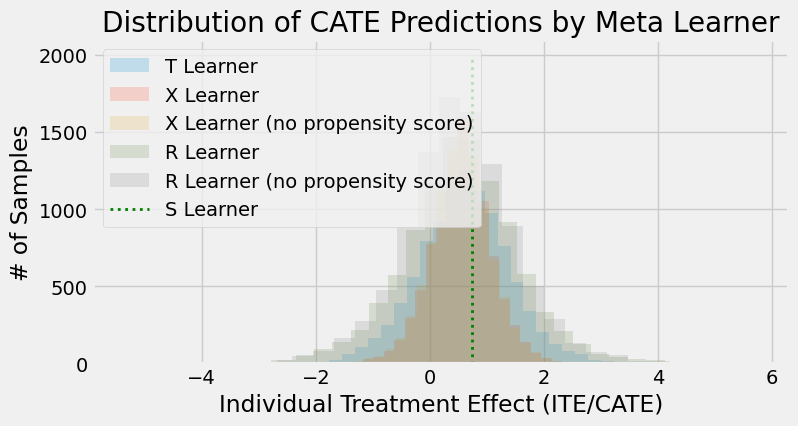

In [20]:
alpha=0.2
bins=30
plt.figure(figsize=(8,4))
plt.hist(cate_t, alpha=alpha, bins=bins, label='T Learner')
plt.hist(cate_x, alpha=alpha, bins=bins, label='X Learner')
plt.hist(cate_x_no_p, alpha=alpha, bins=bins, label='X Learner (no propensity score)')
plt.hist(cate_r, alpha=alpha, bins=bins, label='R Learner')
plt.hist(cate_r_no_p, alpha=alpha, bins=bins, label='R Learner (no propensity score)')
plt.vlines(cate_s[0], 0, 2000, label='S Learner',
           linestyles='dotted', colors='green', linewidth=2)
plt.title('Distribution of CATE Predictions by Meta Learner')
plt.xlabel('Individual Treatment Effect (ITE/CATE)')
plt.ylabel('# of Samples')
_ = plt.legend()

## Meta-Learner的评估精准性

In [16]:
# 从结果可以对比差异还是蛮大的，还有KL Divergence散度指标,注意，simulate_nuisance_and_easy_treatment是一个模拟
# 数据的函数，get_synthetic_summary_holdout模拟之后得到的结论，所以这个函数主要是在模拟运行。
# 如果有真实数据需要自己计算MSE / KL Divergence了。

train_summary, validation_summary = get_synthetic_summary_holdout(simulate_nuisance_and_easy_treatment,
                                                                  n=10000,
                                                                  valid_size=0.2,
                                                                  k=10)

In [17]:
train_summary

,Abs % Error of ATE,MSE,KL Divergence
Actuals,0.000000,0.000000,0.000000
S Learner (LR),0.355777,0.074473,3.699179
S Learner (XGB),0.085519,0.096732,0.270701
T Learner (LR),0.336740,0.032317,0.291573
T Learner (XGB),0.072221,0.586350,0.995245
X Learner (LR),0.336740,0.032317,0.291573
X Learner (XGB),0.058554,0.261599,0.571191
R Learner (LR),0.277822,0.034175,0.292146
R Learner (XGB),0.148537,0.817512,1.070908


In [18]:
validation_summary

,Abs % Error of ATE,MSE,KL Divergence
Actuals,0.000000,0.000000,0.000000
S Learner (LR),0.358637,0.074604,3.854608
S Learner (XGB),0.079207,0.092053,0.275310
T Learner (LR),0.337463,0.032344,0.321732
T Learner (XGB),0.062371,0.382228,0.812662
X Learner (LR),0.337463,0.032344,0.321732
X Learner (XGB),0.060654,0.191946,0.461920
R Learner (LR),0.277791,0.033983,0.321049
R Learner (XGB),0.144737,0.537763,0.899447


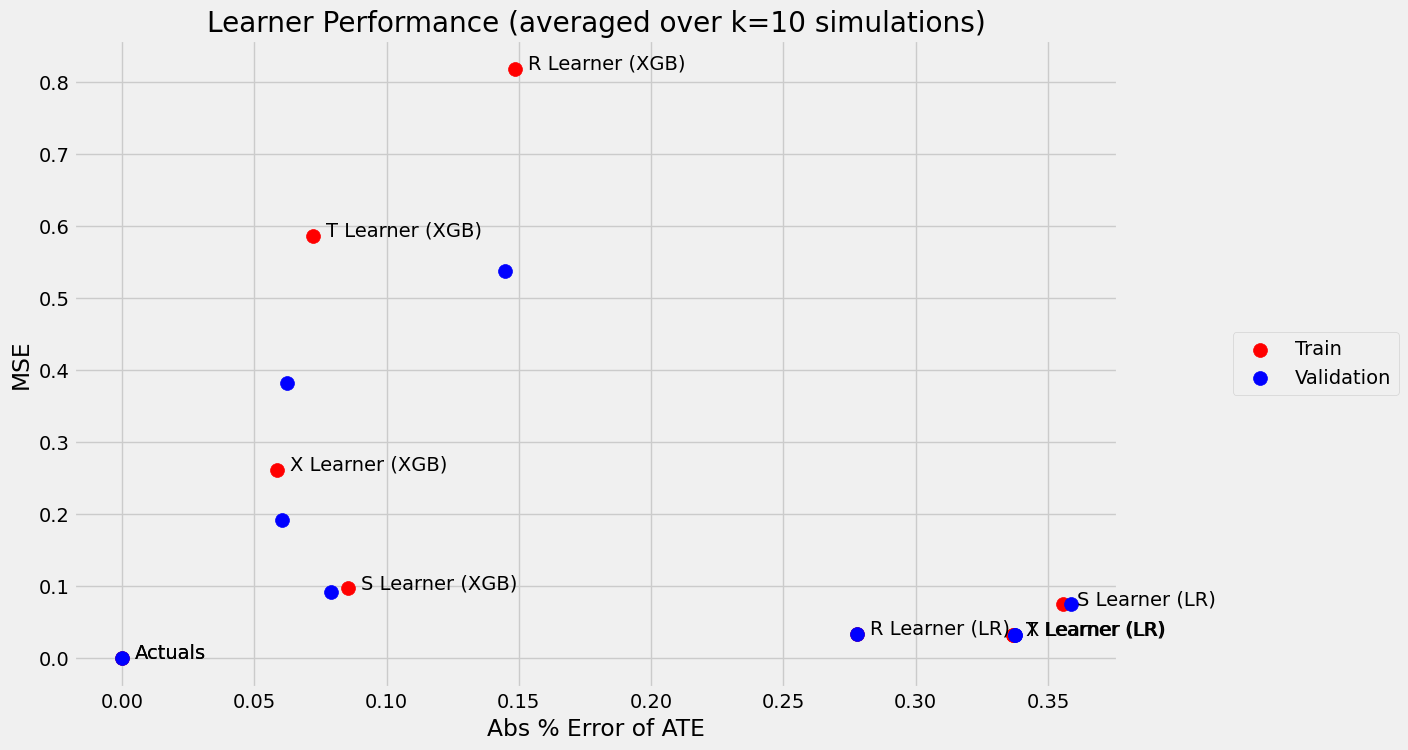

In [21]:
# 按误差再来画一个各模型的对比图
scatter_plot_summary_holdout(train_summary,
                             validation_summary,
                             k=10,
                             label=['Train', 'Validation'],
                             drop_learners=[],
                             drop_cols=[])

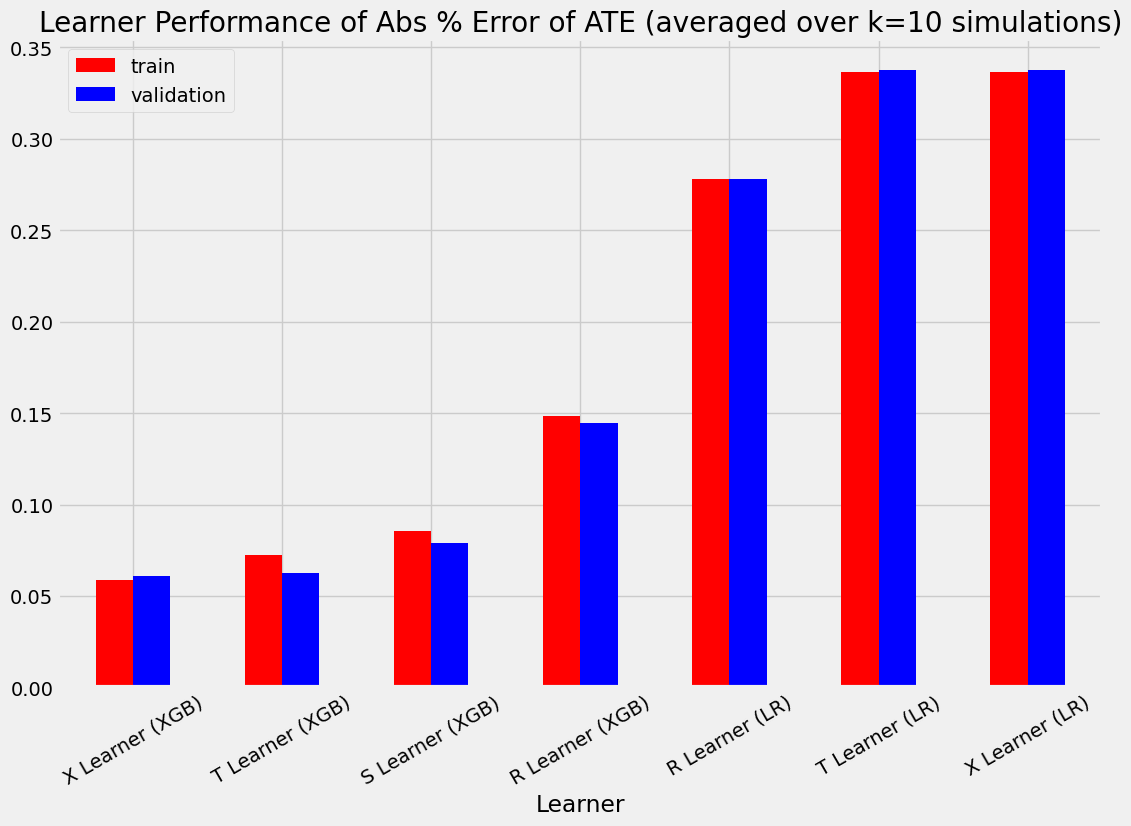

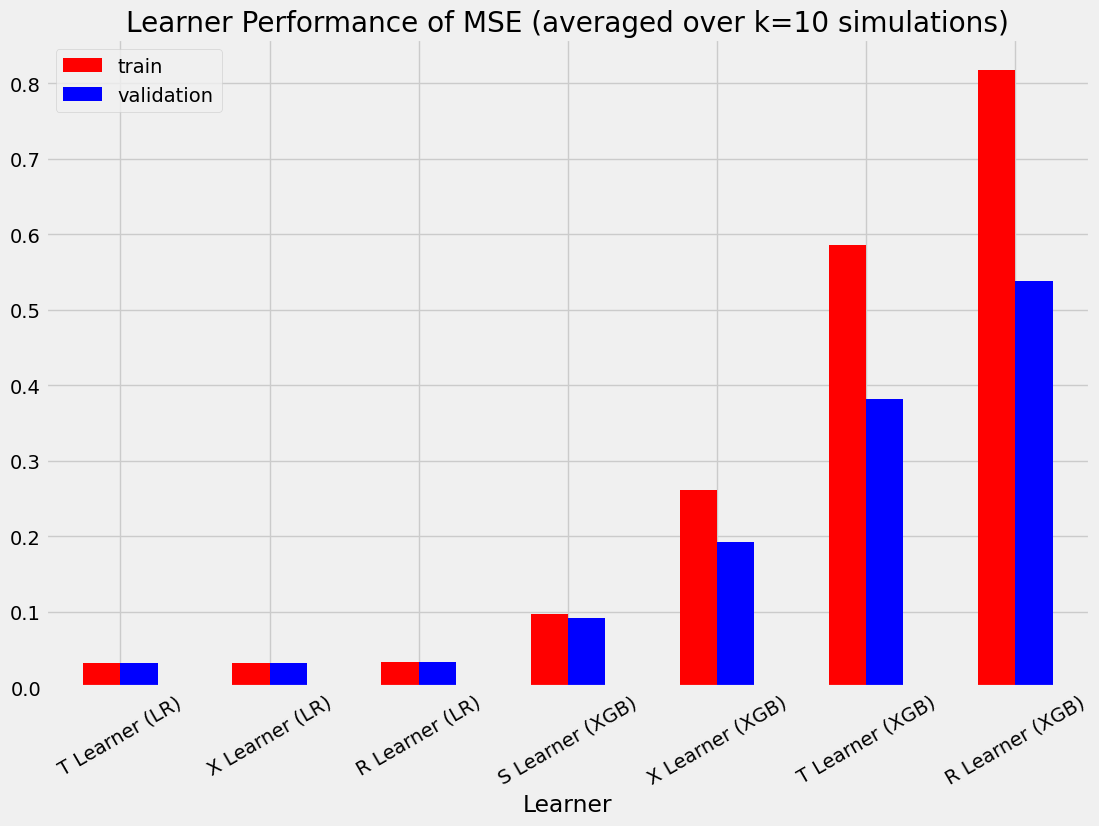

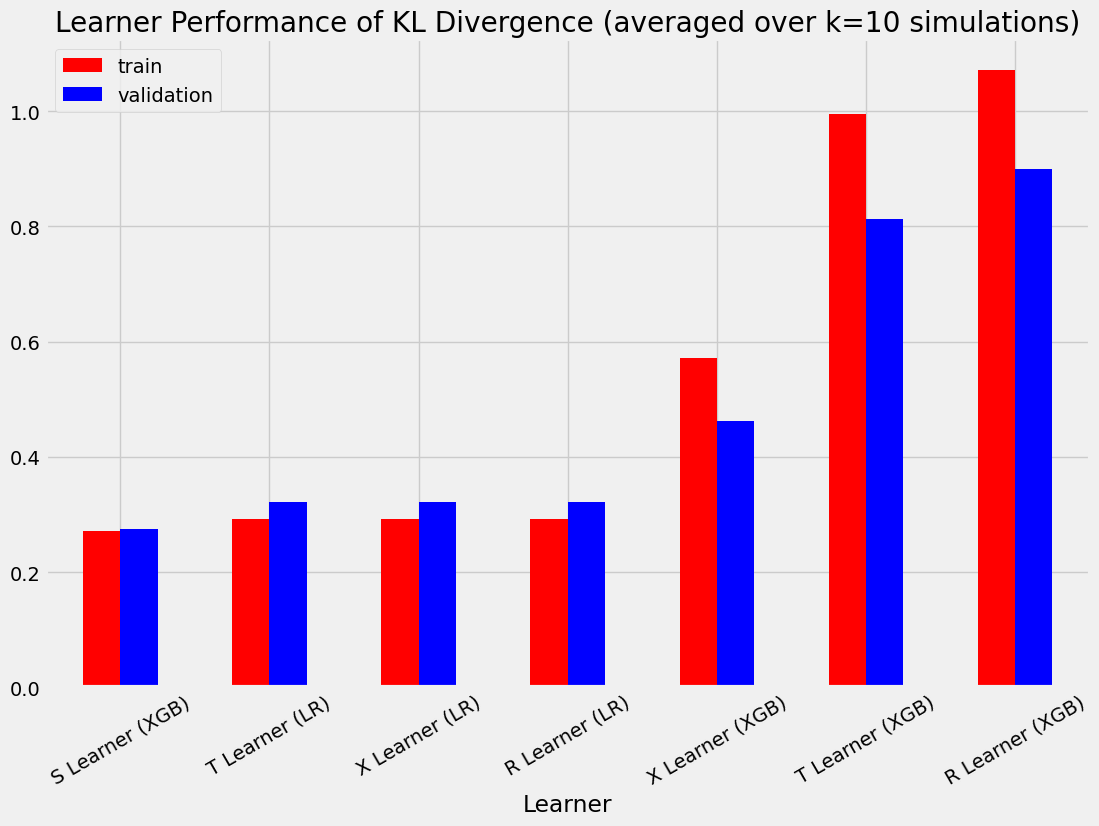

In [22]:
# 三个指标的柱状图，error of ATE / MSE / KL散度
bar_plot_summary_holdout(train_summary,
                         validation_summary,
                         k=10,
                         drop_learners=['S Learner (LR)'],
                         drop_cols=[])

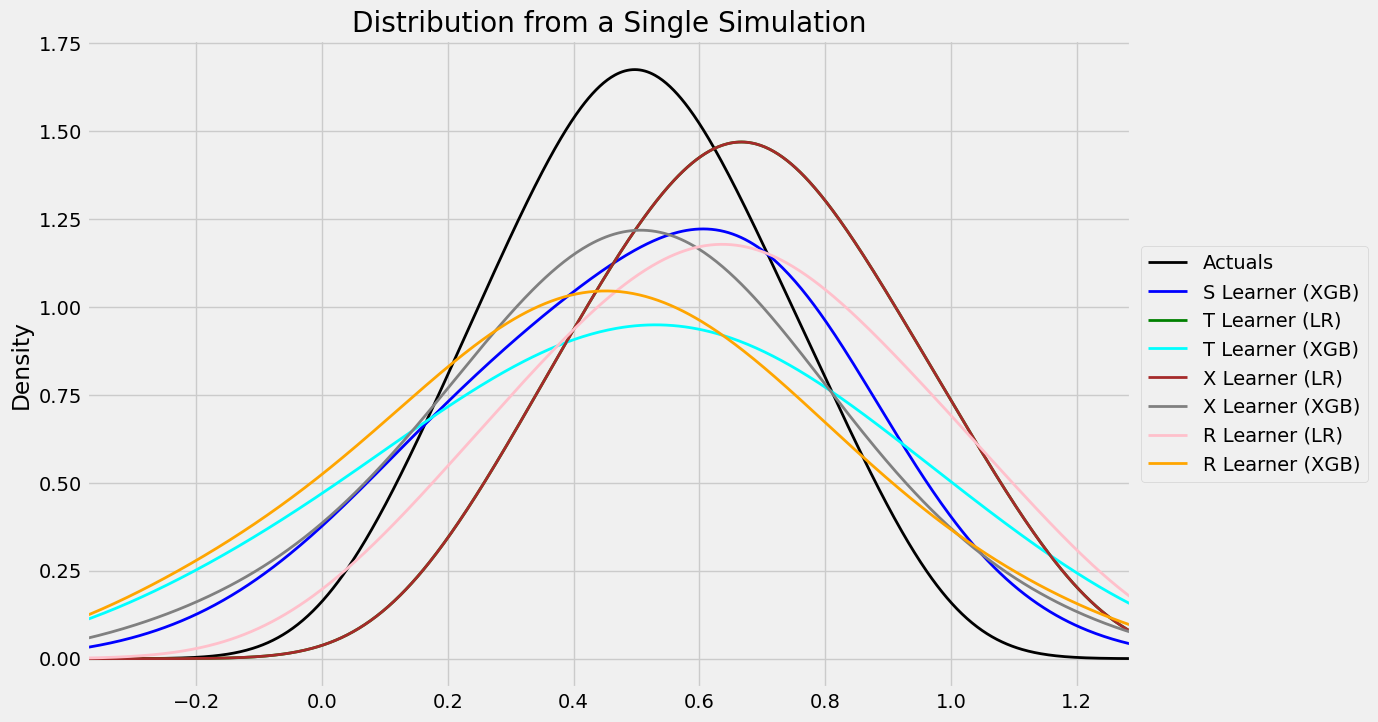

In [23]:
# Single simulation 生成数据
train_preds, valid_preds = get_synthetic_preds_holdout(simulate_nuisance_and_easy_treatment,
                                                       n=50000,
                                                       valid_size=0.2)

#distribution plot for signle simulation of Training 查看数据分布
distr_plot_single_sim(train_preds, kind='kde', linewidth=2, bw_method=0.5,
                      drop_learners=['S Learner (LR)',' S Learner (XGB)'])

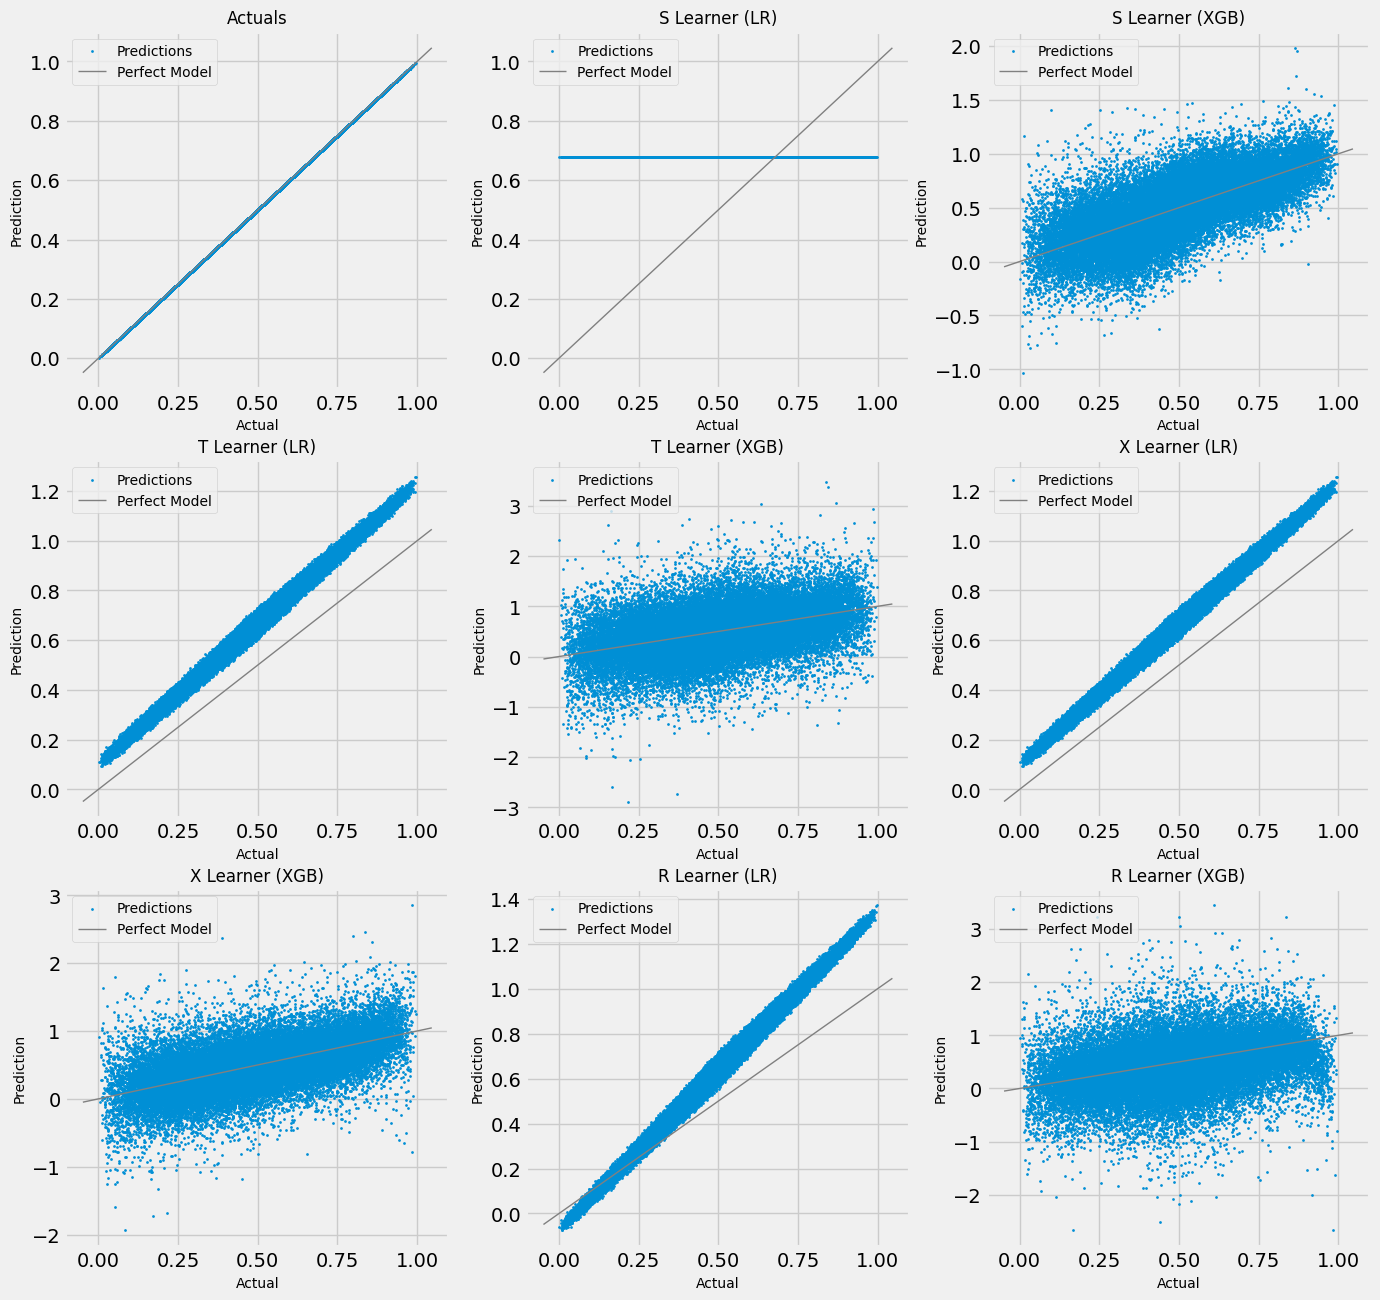

In [24]:
# Scatter Plots for a Single Simulation of Training Data
scatter_plot_single_sim(train_preds)

,Learner,cum_gain_auuc
0,Actuals,4.923301e+06
2,T Learner (LR),4.919282e+06
4,X Learner (LR),4.919282e+06
6,R Learner (LR),4.919146e+06
1,S Learner (XGB),4.660692e+06
5,X Learner (XGB),4.539352e+06
3,T Learner (XGB),4.404712e+06
7,R Learner (XGB),4.346959e+06
8,Random,3.989389e+06


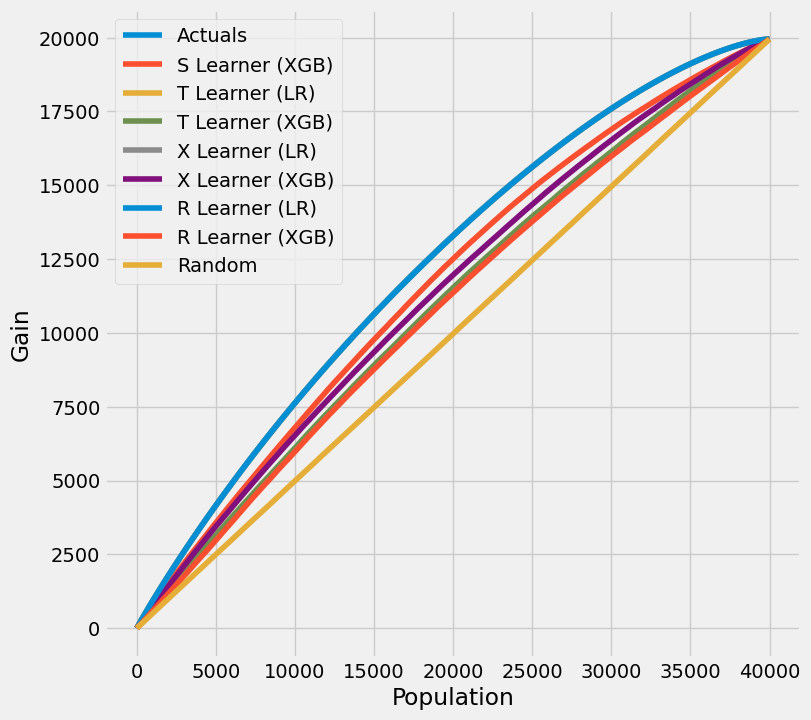

In [25]:
# Cumulative Gain AUUC values for a Single Simulation of Training Data
get_synthetic_auuc(train_preds, drop_learners=['S Learner (LR)'])